In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from classification_models.keras import Classifiers
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras_radam import RAdam
from PIL import Image
import keras
import numpy as np
import cv2
import os

In [2]:
DATASET_PATH = '/home/rauf/datasets/bengali/'
HEIGHT = 137
WIDTH = 236
SIZE = 128

### Functions for 128x128 resizing and read parquet files

In [7]:
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect rsatio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

def create_dataset(file_names):
    file_paths = [os.path.join(DATASET_PATH, file_name) for file_name in file_names]
    data_list = [pd.read_parquet(file_path, engine='pyarrow') for file_path in file_paths]
    data = [df.iloc[:,1:].values.reshape(-1, HEIGHT, WIDTH).astype(np.uint8) for df in data_list]
    data = np.concatenate(data, axis=0)
    del data_list
    return data

def create_cropped_dataset(file_names, size=SIZE):
    data = create_dataset(file_names)
    num_images = data.shape[0]
    data_cropped = np.zeros((num_images, size, size), dtype=np.uint8)
    for idx, image in enumerate(data):
        img = 255 - image
        img = (img*(255.0/img.max())).astype(np.uint8)
        img = crop_resize(img)
        data_cropped[idx,:,:] = img
    del data
    return data_cropped

def save_pngs(data, save_path, file_name_prefix):
    os.makedirs(save_path, exist_ok=True)
    for idx, img in enumerate(data):
        file_name = '{}_{}.png'.format(file_name_prefix, str(idx))
        file_save_path = os.path.join(save_path, file_name)
        cv2.imwrite(file_save_path, img)
        
def show_random_samples(data, n_samples):
    fig, axs = plt.subplots(n_samples, 1, figsize=(10, 5*n_samples))
    total_n_samples = data.shape[0]
    selected_data_idxs = np.random.choice(total_n_samples, n_samples, replace=False)
    selected_data = data[selected_data_idxs,:,:]
    for idx, sample in enumerate(selected_data):
        axs[idx].imshow(sample)
        axs[idx].set_title('Crop & resize')
        axs[idx].axis('off')
    plt.show()

In [8]:
train_file_names = ['parquets/train_image_data_{}.parquet'.format(i) for i in range(4)]
test_file_names = ['parquets/test_image_data_{}.parquet'.format(i) for i in range(4)]

In [9]:
data_train = create_cropped_dataset(train_file_names)
data_test = create_cropped_dataset(test_file_names)

In [10]:
print('Train dataset shape: ', data_train.shape)
print('Test dataset shape: ', data_test.shape)

Train dataset shape:  (200840, 128, 128)
Test dataset shape:  (12, 128, 128)


### Save images as png files

In [11]:
save_path_train = os.path.join(DATASET_PATH, 'pngs/', 'train')
save_path_test = os.path.join(DATASET_PATH, 'pngs/', 'test')
save_pngs(data_train, save_path_train, 'Train')
save_pngs(data_test, save_path_test, 'Test')

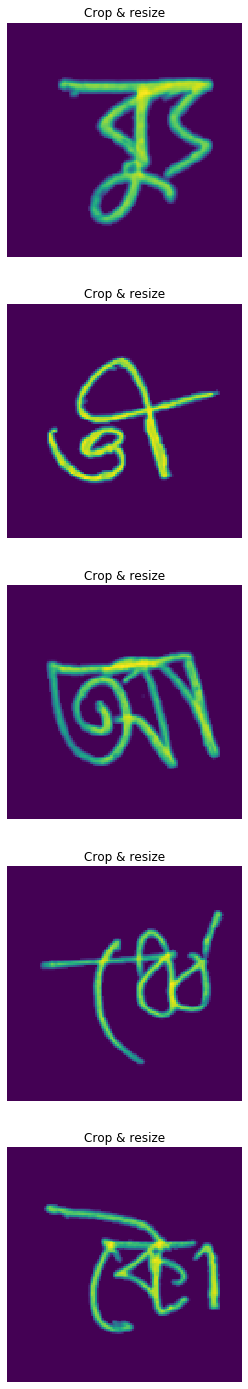

In [12]:
show_random_samples(data_train, 5)

### Analyze csv files

In [19]:
train_csv_file = os.path.join(DATASET_PATH, 'train.csv')
train_df = pd.read_csv(train_csv_file)
train_df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


### Data generator

In [3]:
train_csv_file = os.path.join(DATASET_PATH, 'train.csv')
full_df = pd.read_csv(train_csv_file)
full_df['image_id'] = full_df['image_id'].apply(lambda x: x + '.png') 
full_df.head()

train_df, val_df = train_test_split(full_df, test_size=0.2)

columns = ['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']
images_path_train = os.path.join(DATASET_PATH, 'pngs/','train')
images_path_test = os.path.join(DATASET_PATH, 'pngs/','test')

datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = datagen.flow_from_dataframe(dataframe=train_df,
                                            directory=images_path_train,
                                            x_col="image_id",
                                            y_col=columns,
                                            batch_size=32,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="other",
                                            target_size=(SIZE,SIZE))

val_generator = datagen.flow_from_dataframe(dataframe=val_df,
                                            directory=images_path_train,
                                            x_col="image_id",
                                            y_col=columns,
                                            batch_size=32,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="other",
                                            target_size=(SIZE,SIZE))


# test_generator=test_datagen.flow_from_dataframe(dataframe=df[1900:],
#                                                 directory=images_path_test,
#                                                 x_col="Filenames",
#                                                 batch_size=1,
#                                                 seed=42,
#                                                 shuffle=False,
#                                                 class_mode=None,
#                                                 target_size=(100,100))

Found 160672 validated image filenames.
Found 40168 validated image filenames.


### Classification models

In [10]:
BaseModel, preprocess_input = Classifiers.get('resnet18')
base_model = BaseModel((128, 128, 3), weights='imagenet', include_top=False)

n_classes_grapheme = 168
n_classes_vowel = 11
n_classes_consonant = 7

x = keras.layers.GlobalAveragePooling2D()(base_model.output)
output_grapheme = keras.layers.Dense(n_classes_grapheme, activation='softmax')(x)
output_vowel = keras.layers.Dense(n_classes_vowel, activation='softmax')(x)
output_consonant = keras.layers.Dense(n_classes_consonant, activation='softmax')(x)
model = keras.models.Model(inputs=[base_model.input], 
                           outputs=[output_grapheme, output_vowel, output_consonant])

model.compile(optimizer=RAdam(), loss=['categorical_crossentropy', 
                                     'categorical_crossentropy',
                                     'categorical_crossentropy'], metrics=['accuracy'])

### Train model

In [11]:
def generator_wrapper(generator):
    n_classes = [168, 11, 7]
    for batch_x, batch_y in generator:
        yield (batch_x,[to_categorical(batch_y[:,i], num_classes=n_classes[i]) for i in range(3)])

In [12]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size

model.fit_generator(generator=generator_wrapper(train_generator),
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=generator_wrapper(val_generator),
                    validation_steps=STEP_SIZE_VALID,
                    epochs=1,verbose=1)

Epoch 1/1
 116/5021 [..............................] - ETA: 1:36:14 - loss: 7.5303 - dense_7_loss: 5.0229 - dense_8_loss: 1.4569 - dense_9_loss: 1.0505 - dense_7_accuracy: 0.0426 - dense_8_accuracy: 0.5447 - dense_9_accuracy: 0.6436

KeyboardInterrupt: 